In [75]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score
import scipy.stats as stats
from scipy.stats import norm, t

In [76]:
df = pd.read_csv("/home/hujianjin/projects/LinearRegression_XAUUSD/price_data.csv")



In [77]:
df['Date'] = pd.to_datetime(df['Date'])

In [78]:
df = df.set_index('Date')

In [79]:
df

,Open,High,Low,Close,Tick_Vol
Date,,,,,
2020-01-05,1558.650,1611.25,1540.170,1562.03,417142
2020-01-12,1559.911,1561.44,1535.850,1557.00,288879
2020-01-19,1557.520,1575.73,1546.290,1571.42,263672
2020-01-26,1581.140,1590.29,1563.305,1589.20,368721
2020-02-02,1590.810,1591.88,1547.440,1570.07,347703
...,...,...,...,...,...
2025-05-25,3354.940,3356.54,3245.190,3288.34,1068819
2025-06-01,3298.240,3403.46,3295.220,3309.83,1182423
2025-06-08,3310.530,3446.75,3293.460,3431.88,1159543


In [80]:
# 3-week average
df['SMA_3'] = df['Close'].rolling(window=3).mean()
# 5-week average
df['SMA_5'] = df['Close'].rolling(window=5).mean()
# Short vs long trend signal (3-week vs 5-week)
df['SMA_diff'] = df['SMA_3'] - df['SMA_5']             


In [81]:
# 1-week momentum (current - previous)
df['Momentum_1w'] = df['Close'] - df['Close'].shift(1)
# 2-week momentum (current - 2 weeks ago)
df['Momentum_2w'] = df['Close'] - df['Close'].shift(2)
# % change vs previous week (current - previous) / previous
df['Pct_Change_1w'] = df['Close'].pct_change(periods=1)


In [82]:
# 3-week closing price volatility (std deviation of last 3 weeks)
df['Volatility_3w'] = df['Close'].rolling(window=3).std()


In [83]:
# weekly range
df['Range'] = df['High'] - df['Low']
# weekly range ratio (range / open price)
df['Range_ratio'] = df['Range'] / df['Open']


In [84]:
# Last week's close
df['Close_lag1'] = df['Close'].shift(1) 
# 2 weeks ago close
df['Close_lag2'] = df['Close'].shift(2)


In [85]:
# weekly Close to Open ratio
df['Close_Open_ratio'] = df['Close'] / df['Open']

# weekly Volume Change (current - previous)
df['Volume_Change'] = df['Tick_Vol'] - df['Tick_Vol'].shift(1)

# weekly Volatility
df['Volatility'] = (df['High'] - df['Low']) / df['Open']

# weekly Volatility normalized by tick volume
df['Volatility_per_Tick'] = df['Volatility'] / df['Tick_Vol']



In [86]:
df['High_next_week'] = df['High'].shift(-1)

In [87]:
df

,Open,High,Low,Close,Tick_Vol,SMA_3,SMA_5,SMA_diff,Momentum_1w,Momentum_2w,...,Volatility_3w,Range,Range_ratio,Close_lag1,Close_lag2,Close_Open_ratio,Volume_Change,Volatility,Volatility_per_Tick,High_next_week
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-05,1558.650,1611.25,1540.170,1562.03,417142,NaN,NaN,NaN,NaN,NaN,...,NaN,71.080,0.045604,NaN,NaN,1.002169,NaN,0.045604,1.093238e-07,1561.44
2020-01-12,1559.911,1561.44,1535.850,1557.00,288879,NaN,NaN,NaN,-5.03,NaN,...,NaN,25.590,0.016405,1562.03,NaN,0.998134,-128263.0,0.016405,5.678773e-08,1575.73
2020-01-19,1557.520,1575.73,1546.290,1571.42,263672,1563.483333,NaN,NaN,14.42,9.39,...,7.319032,29.440,0.018902,1557.00,1562.03,1.008924,-25207.0,0.018902,7.168696e-08,1590.29
2020-01-26,1581.140,1590.29,1563.305,1589.20,368721,1572.540000,NaN,NaN,17.78,32.20,...,16.129191,26.985,0.017067,1571.42,1557.00,1.005098,105049.0,0.017067,4.628649e-08,1591.88
2020-02-02,1590.810,1591.88,1547.440,1570.07,347703,1576.896667,1569.944,6.952667,-19.13,-1.35,...,10.676359,44.440,0.027935,1589.20,1571.42,0.986963,-21018.0,0.027935,8.034286e-08,1584.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-25,3354.940,3356.54,3245.190,3288.34,1068819,3281.773333,3280.814,0.959333,-67.48,87.18,...,77.538827,111.350,0.033190,3355.82,3201.16,0.980149,-125606.0,0.033190,3.105284e-08,3403.46
2025-06-01,3298.240,3403.46,3295.220,3309.83,1182423,3317.996667,3295.504,22.492667,21.49,-45.99,...,34.473300,108.240,0.032818,3288.34,3355.82,1.003514,113604.0,0.032818,2.775445e-08,3446.75
2025-06-08,3310.530,3446.75,3293.460,3431.88,1159543,3343.350000,3317.406,25.944000,122.05,143.54,...,77.418510,153.290,0.046304,3309.83,3288.34,1.036656,-22880.0,0.046304,3.993277e-08,3451.21


In [88]:
# Drop unnecessary columns and rows with NaN values
df1 = (
    df.drop(
        columns=[
            'Open', 'High', 'Low', 'Close', 'Tick_Vol'
        ],
        axis=1
    )
    .dropna()
)
df1

,SMA_3,SMA_5,SMA_diff,Momentum_1w,Momentum_2w,Pct_Change_1w,Volatility_3w,Range,Range_ratio,Close_lag1,Close_lag2,Close_Open_ratio,Volume_Change,Volatility,Volatility_per_Tick,High_next_week
Date,,,,,,,,,,,,,,,,
2020-02-02,1576.896667,1569.944,6.952667,-19.13,-1.35,-0.012038,10.676359,44.44,0.027935,1589.20,1571.42,0.986963,-21018.0,0.027935,8.034286e-08,1584.91
2020-02-09,1580.926667,1574.240,6.686667,13.44,-5.69,0.008560,9.823158,23.08,0.014686,1570.07,1589.20,1.007578,-74435.0,0.014686,5.374091e-08,1649.12
2020-02-16,1598.883333,1591.454,7.429333,59.56,73.00,0.037613,38.852343,70.32,0.044447,1583.51,1570.07,1.038537,33097.0,0.044447,1.450794e-07,1689.25
2020-02-23,1604.033333,1594.274,9.759333,-57.55,2.01,-0.035026,33.821680,126.49,0.076510,1643.07,1583.51,0.959032,342761.0,0.076510,1.178660e-07,1691.93
2020-03-01,1633.966667,1611.096,22.870667,87.79,30.24,0.055370,44.597355,116.65,0.073311,1585.52,1643.07,1.051622,-94911.0,0.073311,1.322787e-07,1703.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-18,3293.116667,3286.262,6.854667,154.66,33.45,0.048314,81.374118,161.53,0.050235,3201.16,3322.37,1.043645,-119125.0,0.050235,4.205799e-08,3356.54
2025-05-25,3281.773333,3280.814,0.959333,-67.48,87.18,-0.020108,77.538827,111.35,0.033190,3355.82,3201.16,0.980149,-125606.0,0.033190,3.105284e-08,3403.46
2025-06-01,3317.996667,3295.504,22.492667,21.49,-45.99,0.006535,34.473300,108.24,0.032818,3288.34,3355.82,1.003514,113604.0,0.032818,2.775445e-08,3446.75


In [89]:
# Retrieve the last row of the DataFrame
df2 = (
    df[-1:].drop(
        columns=[
            'Open', 'High', 'Low', 'Close', 'Tick_Vol'
        ],
        axis=1
    )
)
df2

,SMA_3,SMA_5,SMA_diff,Momentum_1w,Momentum_2w,Pct_Change_1w,Volatility_3w,Range,Range_ratio,Close_lag1,Close_lag2,Close_Open_ratio,Volume_Change,Volatility,Volatility_per_Tick,High_next_week
Date,,,,,,,,,,,,,,,,
2025-06-22,3356.586667,3333.586,23.000667,-97.98,-161.93,-0.029092,81.55878,140.83,0.041565,3367.93,3431.88,0.965108,21705.0,0.041565,4.212556e-08,NaN


In [90]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 281 entries, 2020-02-02 to 2025-06-15
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SMA_3                281 non-null    float64
 1   SMA_5                281 non-null    float64
 2   SMA_diff             281 non-null    float64
 3   Momentum_1w          281 non-null    float64
 4   Momentum_2w          281 non-null    float64
 5   Pct_Change_1w        281 non-null    float64
 6   Volatility_3w        281 non-null    float64
 7   Range                281 non-null    float64
 8   Range_ratio          281 non-null    float64
 9   Close_lag1           281 non-null    float64
 10  Close_lag2           281 non-null    float64
 11  Close_Open_ratio     281 non-null    float64
 12  Volume_Change        281 non-null    float64
 13  Volatility           281 non-null    float64
 14  Volatility_per_Tick  281 non-null    float64
 15  High_next_week       

In [91]:
# Feature Engineering
features = [
    'SMA_3', 'SMA_5', 'SMA_diff',
    'Momentum_1w', 'Momentum_2w', 'Pct_Change_1w',
    'Volatility_3w', 'Range', 'Range_ratio',
    'Close_lag1', 'Close_lag2', 'Close_Open_ratio',
    'Volume_Change', 'Volatility', 'Volatility_per_Tick'
]

In [92]:
# Select features and target values
X = df1[features].values
y = df1['High_next_week'].values

In [93]:
# Final Holdout Split (80% train, 20% test)
split_index = int(len(X) * 0.8)

X_train_full, X_test = X[:split_index], X[split_index:]
y_train_full, y_test = y[:split_index], y[split_index:]

In [94]:
# Display basic information about the datasets
print(f"X_train_full shape: {X_train_full.shape}")
print(f"y_train_full shape: {y_train_full.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test_shape: {y_test.shape}")

X_train_full shape: (224, 15)
y_train_full shape: (224,)
X_test shape: (57, 15)
y_test_shape: (57,)


In [95]:
# Scale numeric features
scaler = StandardScaler()
X_train_full_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

In [96]:
# Initialize TimeSeriesSplit for model evaluation only
# no hyperparameter tuning in this example
tscv = TimeSeriesSplit(n_splits=5)

# Lists to store scores
mae_scores = []
mse_scores = []
rmse_scores = []
mape_scores = []
r2_scores = []

# Time series cross-validation loop
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_full_scaled)):
    X_train_scaled, X_val_scaled = X_train_full_scaled[train_idx], X_train_full_scaled[val_idx]
    y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    y_val_pred = model.predict(X_val_scaled)

    # Compute metrics
    mae = mean_absolute_error(y_val, y_val_pred)
    mse = mean_squared_error(y_val, y_val_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_val, y_val_pred)*100
    r2 = r2_score(y_val, y_val_pred)

    # Store scores
    mae_scores.append(mae)
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mape_scores.append(mape)
    r2_scores.append(r2)

    print(f"Fold {fold + 1}: MAE = {mae:.4f}, MSE = {mse:.4f}, RMSE = {rmse:.4f}, MAPE = {mape:.4f}, R² = {r2:.4f}")

# Print average scores
print("\nAverage CV Scores:")
print(f"MAE:  {np.mean(mae_scores):.4f}")
print(f"MSE:  {np.mean(mse_scores):.4f}")
print(f"RMSE: {np.mean(rmse_scores):.4f}")
print(f"MAPE: {np.mean(mape_scores):.4f}")
print(f"R²:   {np.mean(r2_scores):.4f}")


Fold 1: MAE = 21.6952, MSE = 747.1174, RMSE = 27.3334, MAPE = 1.1808, R² = 0.7929
Fold 2: MAE = 17.1265, MSE = 444.6739, RMSE = 21.0873, MAPE = 0.9138, R² = 0.9092
Fold 3: MAE = 19.7283, MSE = 617.7356, RMSE = 24.8543, MAPE = 1.0921, R² = 0.9098
Fold 4: MAE = 17.4012, MSE = 649.3505, RMSE = 25.4824, MAPE = 0.8844, R² = 0.8090
Fold 5: MAE = 28.5646, MSE = 1318.3219, RMSE = 36.3087, MAPE = 1.3198, R² = 0.9512

Average CV Scores:
MAE:  20.9032
MSE:  755.4399
RMSE: 27.0132
MAPE: 1.0782
R²:   0.8744


In [97]:
# Fit model on Full Training Set
model.fit(X_train_full_scaled, y_train_full)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [98]:
# Prediction on full training set
y_train_full_pred = model.predict(X_train_full_scaled)

In [99]:
# Prediction on Test Set
y_test_pred = model.predict(X_test_scaled)

In [100]:
results = pd.DataFrame({
    "predicted": y_test_pred,          # model's predicted high price
    "actual": y_test                   # actual high prices
})
print(results)

      predicted    actual
0   2366.754050  2363.962
1   2364.024887  2387.612
2   2323.933462  2341.555
3   2362.712497  2368.599
4   2348.676317  2339.569
5   2353.521609  2392.840
6   2432.148369  2424.419
7   2452.695631  2483.559
8   2433.175205  2431.895
9   2412.804437  2477.509
10  2489.547115  2458.649
11  2462.487154  2509.640
12  2552.943399  2531.559
13  2553.323144  2528.930
14  2524.969259  2529.129
15  2526.593135  2585.990
16  2630.254521  2625.670
17  2676.082764  2685.510
18  2704.213188  2673.070
19  2683.354987  2661.325
20  2686.176621  2722.419
21  2768.038471  2758.310
22  2788.796671  2790.040
23  2749.692382  2749.779
24  2712.781982  2686.071
25  2594.335895  2716.189
26  2790.847842  2721.067
27  2680.322672  2656.979
28  2672.798111  2725.860
29  2689.647731  2664.260
30  2646.062537  2638.929
31  2641.401868  2665.186
32  2670.268758  2697.825
33  2737.710522  2724.667
34  2741.395630  2785.820
35  2825.230899  2816.879
36  2845.228854  2886.590
37  2919.096

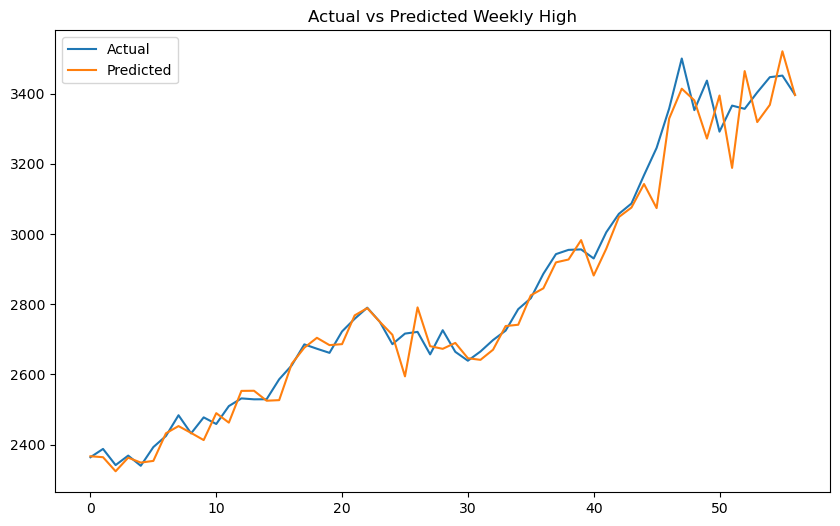

In [101]:
# Plot actual vs predicted line chart on test data
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.title("Actual vs Predicted Weekly High")
plt.legend()
plt.show()

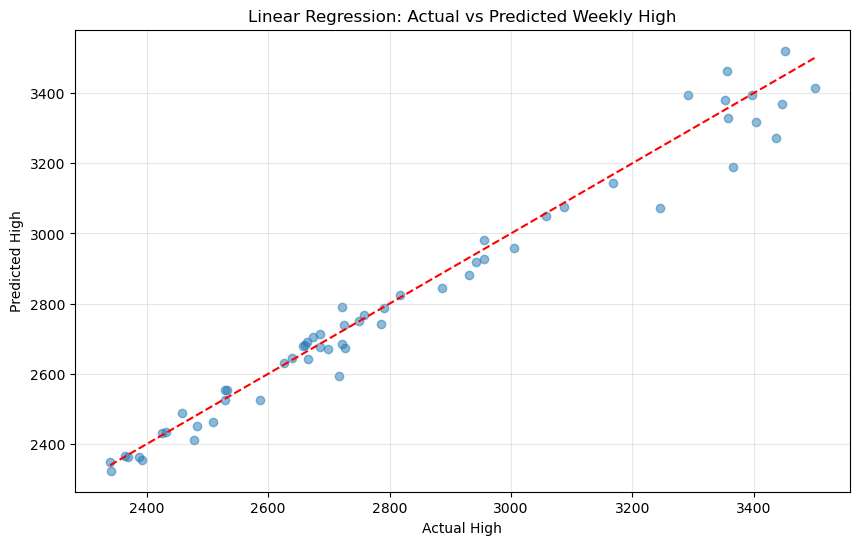

In [102]:
# Plot actual vs predicted scatter plot on test data
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual High')
plt.ylabel('Predicted High')
plt.title('Linear Regression: Actual vs Predicted Weekly High')
plt.grid(True, alpha=0.3)

In [103]:
# Compute performance metrics on test data

model_test_mae = mean_absolute_error(y_test, y_test_pred)
model_test_mse = mean_squared_error(y_test, y_test_pred)
model_test_rmse = np.sqrt(model_test_mse)
model_test_mape = mean_absolute_percentage_error(y_test, y_test_pred)*100
model_test_r2 = r2_score(y_test, y_test_pred)

# Print results
print(f"Linear Regression Performance on Test Data:")
print(f"Model - MAE:  {model_test_mae:.4f}")
print(f"        MSE:  {model_test_mse:.4f}")
print(f"        RMSE: {model_test_rmse:.4f}")
print(f"        MAPE: {model_test_mape:.4f}")
print(f"        R²:   {model_test_r2:.4f}")

Linear Regression Performance on Test Data:
Model - MAE:  40.5271
        MSE:  3389.1240
        RMSE: 58.2162
        MAPE: 1.3646
        R²:   0.9717


In [104]:
# retrieve the last row of the DataFrame
df2

,SMA_3,SMA_5,SMA_diff,Momentum_1w,Momentum_2w,Pct_Change_1w,Volatility_3w,Range,Range_ratio,Close_lag1,Close_lag2,Close_Open_ratio,Volume_Change,Volatility,Volatility_per_Tick,High_next_week
Date,,,,,,,,,,,,,,,,
2025-06-22,3356.586667,3333.586,23.000667,-97.98,-161.93,-0.029092,81.55878,140.83,0.041565,3367.93,3431.88,0.965108,21705.0,0.041565,4.212556e-08,NaN


In [105]:
# Select last row features
X_last = df2[features]

In [106]:
# Scale the last row features using the previously fitted scaler
X_last_scaled = scaler.transform(X_last)

/home/hujianjin/miniconda3/envs/forecasting_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [107]:
# Predict the next week's high price
predicted_next = model.predict(X_last_scaled)

# Extract scalar values from the prediction
predicted_next = predicted_next[0]

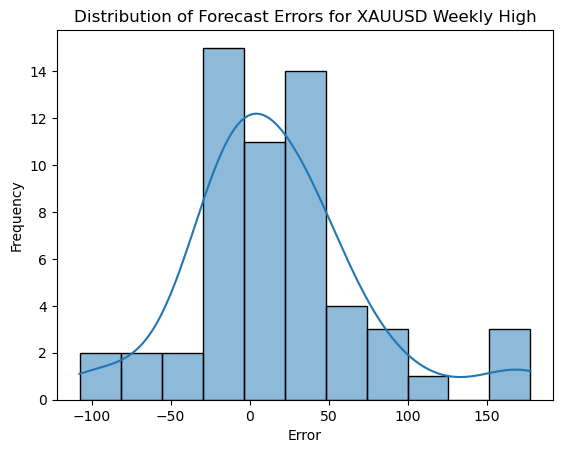

In [108]:
# Histogram + density curve of forecast errors
errors = y_test - y_test_pred  # residuals/errors
sns.histplot(errors, kde=True)
plt.title("Distribution of Forecast Errors for XAUUSD Weekly High")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()

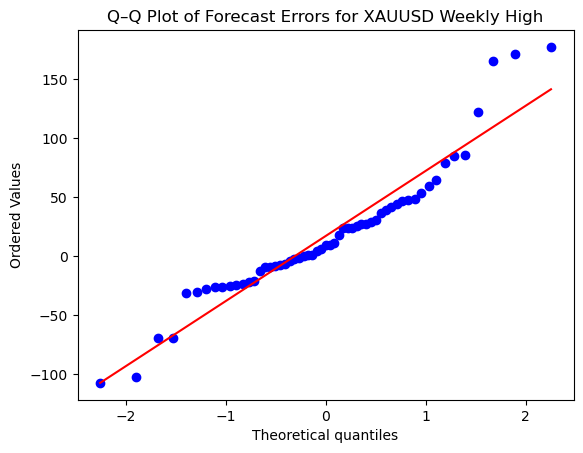

In [109]:
# Q–Q Plot of forecast errors
stats.probplot(errors, dist="norm", plot=plt)
plt.title("Q–Q Plot of Forecast Errors for XAUUSD Weekly High")
plt.show()

In [110]:
# Function to calculate probabilistic ranges based on RMSE and MAPE

def probabilistic_ranges(predicted_price, rmse, mape, confidence=0.68, n=None):
    """
    Calculate RMSE-based and MAPE-based probabilistic ranges for a predicted value.
    Automatically uses t-distribution if sample size (n) is provided and n < 100.
    
    Parameters:
        predicted_price (float): The model's predicted price.
        rmse (float): Root Mean Squared Error from test data.
        mape (float): Mean Absolute Percentage Error from test data (in % or decimal).
        confidence (float): Desired probability level (e.g., 0.68 for 68%).
        n (int): Sample size (number of predictions in the test dataset used to compute RMSE/MAPE).
    
    Returns:
        dict: Contains both RMSE-based and MAPE-based ranges with bounds.
    """
    # Ensure MAPE is in decimal form
    if mape > 1:
        mape = mape / 100.0
    
    # Choose correct distribution for critical value
    if n is not None and n < 100:
        z_or_t = t.ppf(0.5 + confidence / 2, df=n - 1)
        dist_used = "t-distribution"
    else:
        z_or_t = norm.ppf(0.5 + confidence / 2)
        dist_used = "z-distribution"
    
    # --- RMSE-based ---
    rmse_margin = z_or_t * rmse
    rmse_lower = predicted_price - rmse_margin
    rmse_upper = predicted_price + rmse_margin
    
    # --- MAPE-based ---
    sigma_pct = mape / 0.8  # Approx std dev of % errors
    mape_margin_pct = z_or_t * sigma_pct
    mape_lower = predicted_price * (1 - mape_margin_pct)
    mape_upper = predicted_price * (1 + mape_margin_pct)
    
    return {
        "confidence": confidence,
        "critical_value": z_or_t,
        "distribution_used": dist_used,
        "rmse_based": {
            "margin_abs": rmse_margin,
            "lower": rmse_lower,
            "upper": rmse_upper
        },
        "mape_based": {
            "margin_pct": mape_margin_pct * 100,  # in %
            "lower": mape_lower,
            "upper": mape_upper
        }
    }

# -------------------------
# Example usage
predicted_price = 3319.0292
rmse = 58.2162
mape = 1.3646  # in %
n = 57  # size of test dataset

ranges = probabilistic_ranges(predicted_price, rmse, mape, confidence=0.68, n=n)

print(f"--- {ranges['confidence']*100:.0f}% Probabilistic Ranges ({ranges['distribution_used']}) ---")
print(f"Predicted <2025-06-29> High Price: {predicted_next:.4f}")
print(f"RMSE-based: {ranges['rmse_based']['lower']:.2f} – {ranges['rmse_based']['upper']:.2f} "
      f"(±{ranges['rmse_based']['margin_abs']:.2f})")
print(f"MAPE-based: {ranges['mape_based']['lower']:.2f} – {ranges['mape_based']['upper']:.2f} "
      f"(±{ranges['mape_based']['margin_pct']:.2f}%)")


--- 68% Probabilistic Ranges (t-distribution) ---
Predicted <2025-06-29> High Price: 3319.0292
RMSE-based: 3260.62 – 3377.44 (±58.41)
MAPE-based: 3262.22 – 3375.83 (±1.71%)


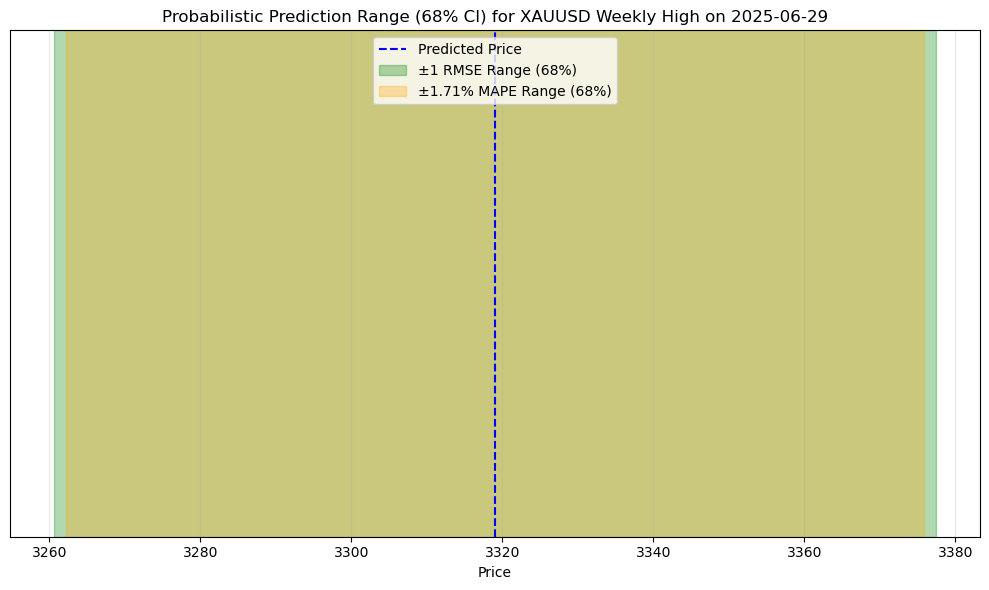

In [111]:
# Prediction details
pred_date = "2025-06-29"
predicted_price = 3319.0292

# Confidence intervals
rmse_low, rmse_high = 3260.62, 3377.44
mape_low, mape_high = 3262.22, 3375.83

# Plot
plt.figure(figsize=(10, 6))
plt.axvline(predicted_price, color='blue', linestyle='--', label='Predicted Price')

# RMSE-based range
plt.axvspan(rmse_low, rmse_high, color='green', alpha=0.3, label='±1 RMSE Range (68%)')

# MAPE-based range
plt.axvspan(mape_low, mape_high, color='orange', alpha=0.3, label='±1.71% MAPE Range (68%)')

# Labels and formatting
plt.title(f"Probabilistic Prediction Range (68% CI) for XAUUSD Weekly High on {pred_date}")
plt.xlabel("Price")
plt.yticks([])
plt.legend(loc='upper center')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()